<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Variables-to-control" data-toc-modified-id="Variables-to-control-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Variables to control</a></span></li><li><span><a href="#Auxiliary-functions" data-toc-modified-id="Auxiliary-functions-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Auxiliary functions</a></span></li><li><span><a href="#Fidelity-Calculations" data-toc-modified-id="Fidelity-Calculations-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Fidelity Calculations</a></span></li><li><span><a href="#Prepare-results-to-plot" data-toc-modified-id="Prepare-results-to-plot-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Prepare results to plot</a></span></li><li><span><a href="#Plot-results" data-toc-modified-id="Plot-results-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Plot results</a></span></li></ul></div>

# Analysis for a 3 quantum damping channel discrimination

In [16]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

from qcd import load_object_from_file
from qcd.typings.configurations import OptimalConfigurations
from qcd.configurations import ChannelConfiguration, OneShotConfiguration, OneShotEntangledConfiguration
from typing import Optional, Tuple, cast, List, Dict
from qutip import *
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, Aer, execute
from qiskit.quantum_info.states.utils import partial_trace
from qiskit.quantum_info import DensityMatrix
from qiskit.result.result import Result
import numpy as np
import math
import matplotlib.pyplot as plt

## Variables to control

In [17]:
# Filenames with results for 3 etas and their optimized parameters to LOAD
# filename = '20210417_C2_A2_100_100_3_6_20'
filename = '20210418a_C2_A1_1000_100000_3_6_20'
path = 'results/'
GLOBAL_BACKEND = Aer.get_backend('statevector_simulator')

## Auxiliary functions

In [18]:
def get_number_eta_pairs(eta_groups)->Tuple[int, List[Tuple[int, int]]]:
    number_eta_pairs = 0
    eta0 = -1
    eta1 = -1
    eta_pairs = []
    for eta_group in eta_groups:
        if eta_group[0] != eta0 or eta_group[1] != eta1:
            number_eta_pairs += 1
            eta0 = eta_group[0]
            eta1 = eta_group[1]
            eta_pairs.append((int(math.degrees(eta0)), int(math.degrees(eta1))))
    return (number_eta_pairs, eta_pairs)

In [19]:
def _prepare_initial_state_entangled(state_probability: float) -> Tuple[complex, complex, complex, complex]:
    """ Prepare initial state: computing 'y' as the amplitudes  """
    return (0, np.sqrt(state_probability), np.sqrt(1 - state_probability), 0)

In [5]:
def _create_one_circuit(configuration: ChannelConfiguration,
                        eta: float) -> QuantumCircuit:
    """ Creates one circuit from a given  configuration and eta """
    configuration = cast(OneShotEntangledConfiguration, configuration)
    qreg_q = QuantumRegister(3, 'q')
    creg_c = ClassicalRegister(2, 'c')

    initial_state = _prepare_initial_state_entangled(configuration.state_probability)

    circuit = QuantumCircuit(qreg_q, creg_c)
    circuit.initialize(initial_state, [0, 1])
    circuit.reset(qreg_q[2])
    circuit.cry(2 * eta, qreg_q[1], qreg_q[2])
    circuit.cx(qreg_q[2], qreg_q[1])
    circuit.cx(qreg_q[0], qreg_q[1])
    circuit.h(qreg_q[0])
    circuit.rx(configuration.angle_rx1, qreg_q[1])
    circuit.ry(configuration.angle_ry1, qreg_q[1])
    circuit.rx(configuration.angle_rx0, qreg_q[0])
    circuit.ry(configuration.angle_ry0, qreg_q[0])
    return circuit

In [6]:
def _run_all_circuits_and_return_density_matrices(configuration: ChannelConfiguration)-> Tuple[DensityMatrix, 
                                                                                               DensityMatrix, 
                                                                                               DensityMatrix]:
    """ Create a pair of Quantum Circuits, in its transpiled form, from a given configuration """
    state_vectors = [execute(_create_one_circuit(configuration, eta),
                                         backend=GLOBAL_BACKEND).result().get_statevector()
                        for eta in configuration.eta_group]
    if len(state_vectors) < 3:
        raise ValueError('State Vector length less than 3')
    pt0 = partial_trace(np.outer(state_vectors[0],state_vectors[0].conj()), [2])
    pt1 = partial_trace(np.outer(state_vectors[1],state_vectors[1].conj()), [2])
    pt2 = partial_trace(np.outer(state_vectors[2],state_vectors[2].conj()), [2])
    return (pt0, pt1, pt2)

## Fidelity Calculations

In [7]:
def upper_bound_fidelity(fidelity1: float, fidelity2: float, fidelity3: float) -> float:
    return ((1/3) * fidelity1) + ((1/3) * fidelity2) + ((1/3) * fidelity3)

def lower_bound_fidelity(fidelity1: float, fidelity2: float, fidelity3: float) -> float:
    return (1/2) * (((1/9) * fidelity1**2) +((1/9) * fidelity2**2) + ((1/9) * fidelity3**2))

In [8]:
def compute_upper_and_lower_fidelity_bounds(optimal_configuration: OneShotConfiguration)-> Tuple[float, float]:
    density_matrices = _run_all_circuits_and_return_density_matrices(optimal_configuration)
    out_fidelity1 = fidelity(Qobj(density_matrices[0].data), Qobj(density_matrices[1].data))
    out_fidelity2 = fidelity(Qobj(density_matrices[0].data), Qobj(density_matrices[2].data))
    out_fidelity3 = fidelity(Qobj(density_matrices[1].data), Qobj(density_matrices[2].data))

    return (upper_bound_fidelity(out_fidelity1, out_fidelity2, out_fidelity3), 
            lower_bound_fidelity(out_fidelity1, out_fidelity2, out_fidelity3))

## Prepare results to plot

In [9]:
def get_etas_probabilities_and_fidelities_from_optimal_results(optimal_results: OptimalConfigurations)-> List[dict]:
    """ From the optimal results, obtain the etas and the result probabilities for each 3-eta execution.
        Return a list of etas used (in degrees) and the probabilities with the associated eta pair.
    """
    error_probabilities = []
    etas_third_channel = []
    upper_fidelities = []
    lower_fidelities = []
    
    for idx, configuration in enumerate(optimal_results['configurations']):
        etas_third_channel.append(int(math.degrees(cast(OneShotConfiguration, configuration).eta_group[2])))
        error_probabilities.append(1 - optimal_results['probabilities'][idx])
        upper_fidelity, lower_fidelity =  compute_upper_and_lower_fidelity_bounds(cast(OneShotConfiguration, configuration))
        upper_fidelities.append(upper_fidelity)
        lower_fidelities.append(lower_fidelity)

    number_eta_pairs, eta_unique_pairs = get_number_eta_pairs(eta_groups=optimal_results['eta_groups'])
    number_third_channels = int(len(optimal_results['eta_groups']) / number_eta_pairs)

    results_to_plot = [{'error_probabilities': error_probabilities[idx * number_third_channels: (idx+1)*number_third_channels],
                        'etas_third_channel': etas_third_channel[idx * number_third_channels: (idx+1)*number_third_channels],
                        'upper_fidelities': upper_fidelities[idx * number_third_channels: (idx+1)*number_third_channels],
                        'lower_fidelities': lower_fidelities[idx * number_third_channels: (idx+1)*number_third_channels],
                        'eta_pair': eta_pair} 
                       for idx, eta_pair in enumerate(eta_unique_pairs)]
    return results_to_plot
    

In [14]:
def plot_3channel_results(parsed_results: List[dict], algorithm:str = '')-> None:
    number_third_etas = len(parsed_results)
    
    fig = plt.figure(figsize=(25, 10))
    sup_title = 'Error Probabilities'
    sup_title += f' with {algorithm}' if algorithm != '' else ''
    fig.suptitle(sup_title, fontsize=20)
    
    for idx, parsed_result in enumerate(parsed_results):
        title = f"Eta pair ({parsed_result['eta_pair'][0]}\u00B0,{parsed_result['eta_pair'][1]}\u00B0)"
        ax = fig.add_subplot(2, 3, idx+1 % 3)
        ax.set_ylim([0,1])
        ax.set_title(title, fontsize=14)
        ax.set_xlabel('Channel 3 (angle $\eta$)')
        ax.set_ylabel('Probability Error')
        ax.axvline(x=parsed_result['eta_pair'][0], linestyle='dotted', color='lightcoral', label=f"eta0 = {parsed_result['eta_pair'][0]}\u00B0")
        ax.axvline(x=parsed_result['eta_pair'][1], linestyle='dotted', color='firebrick', label=f"eta1 = {parsed_result['eta_pair'][1]}\u00B0")
        ax.plot(parsed_result['etas_third_channel'], parsed_result['error_probabilities'], label='Perr')
        ax.plot(parsed_result['etas_third_channel'], parsed_result['upper_fidelities'], label='Upper Bound')
        ax.plot(parsed_result['etas_third_channel'], parsed_result['lower_fidelities'], label='Lower Bound')
        ax.legend()
    plt.show()

## Plot results

In [11]:
results = load_object_from_file(name=filename, path=path)

In [12]:
parsed_results = get_etas_probabilities_and_fidelities_from_optimal_results(optimal_results=results)

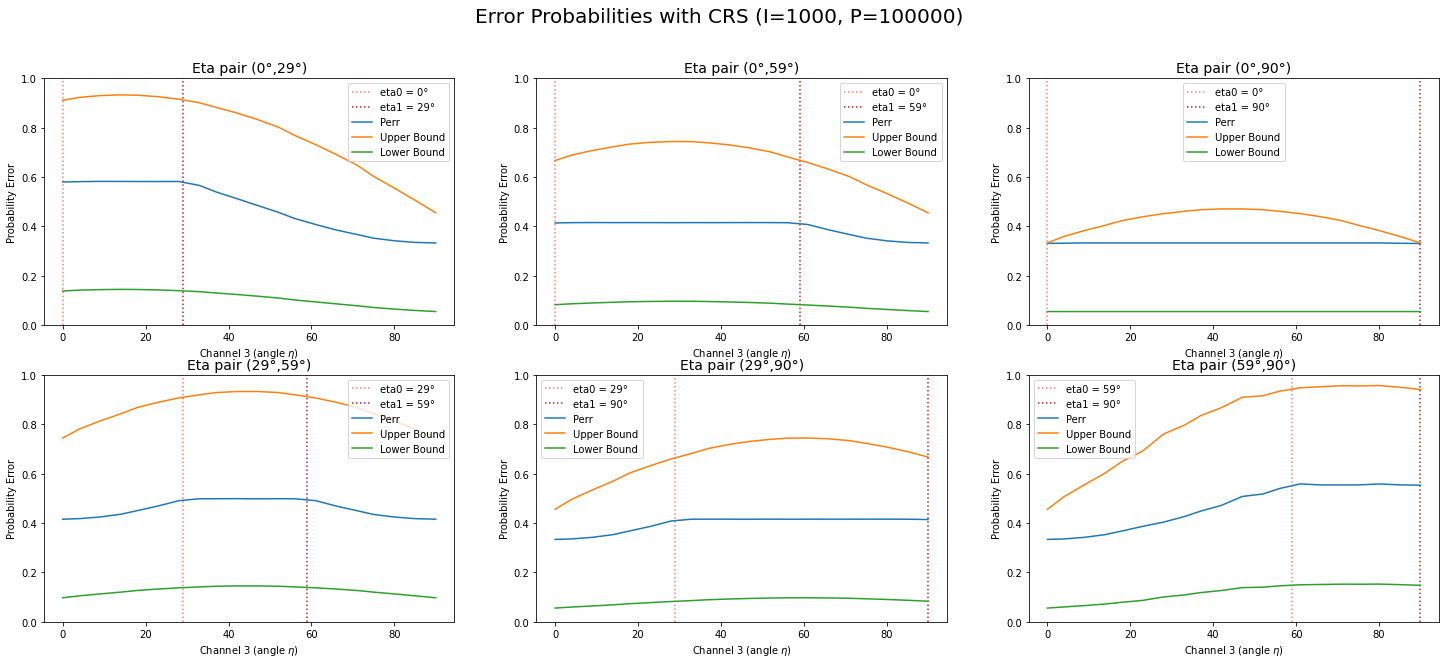

In [15]:
plot_3channel_results(parsed_results=parsed_results, algorithm='CRS (I=1000, P=100000)')

In [62]:
results_crs = load_object_from_file(name='20210416a_C2_A1_1000_10000_3_6_20', path='../demo/data/')
parsed_crs_results = get_etas_and_probabilities_from_optimal_results(optimal_results=results_crs)

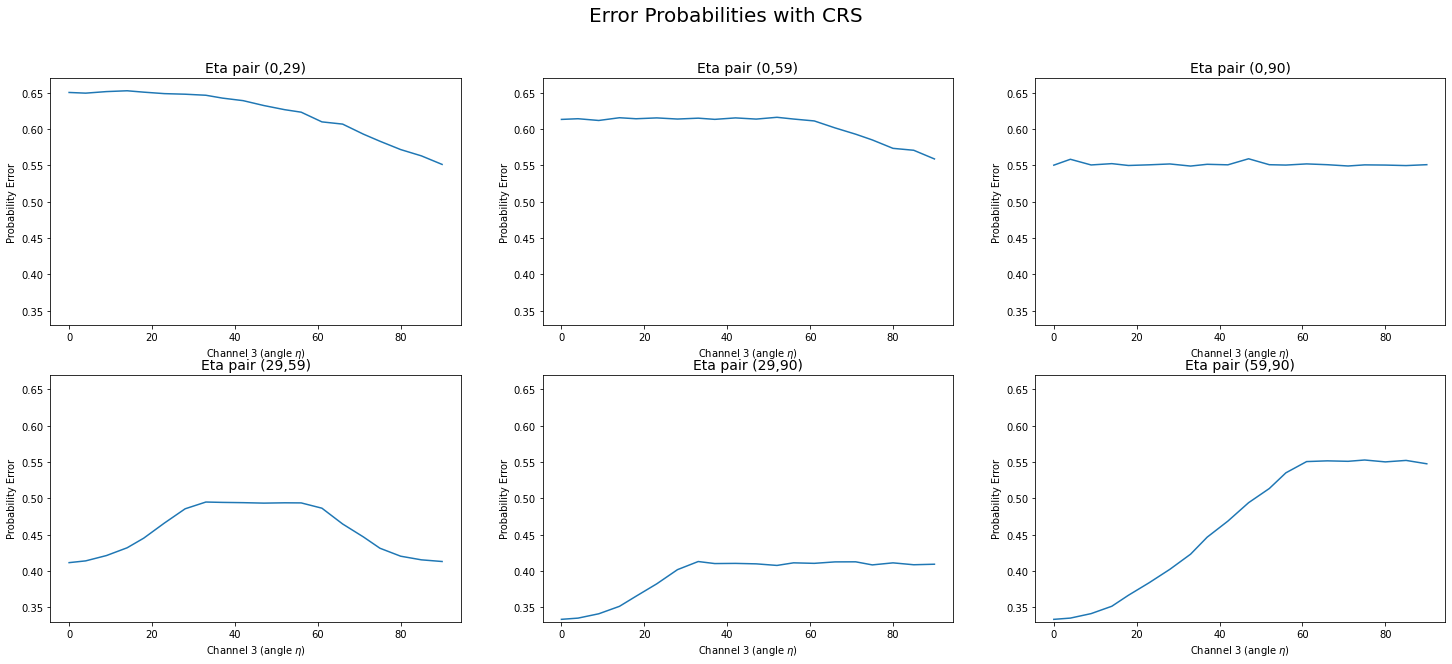

In [83]:
plot_3channel_results(parsed_results=parsed_crs_results, algorithm='CRS')

In [66]:
results_ESCH = load_object_from_file(name='20210416b_C2_A4_A5_1000_10000_3_6_20', path='../demo/data/')
parsed_ESCH_results = get_etas_and_probabilities_from_optimal_results(optimal_results=results_ESCH)

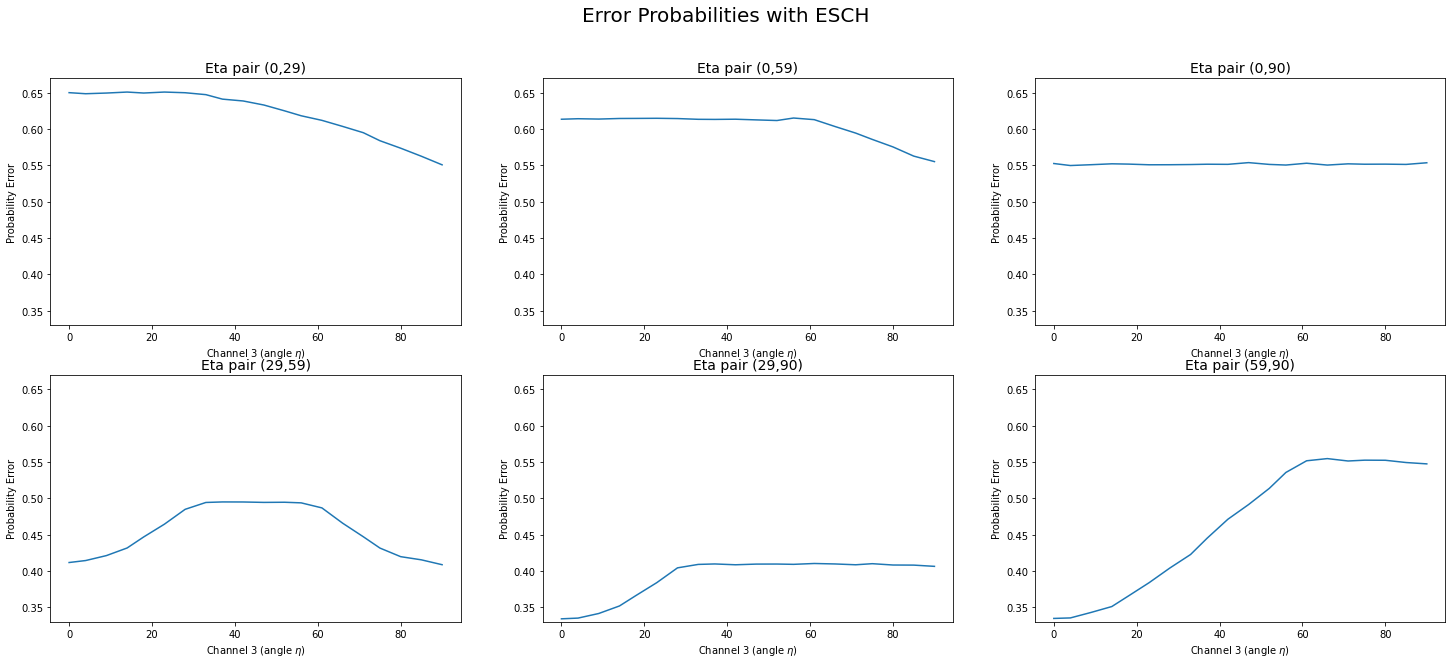

In [84]:
plot_3channel_results(parsed_results=parsed_ESCH_results, algorithm='ESCH')

In [56]:
len(results_other)

5

In [57]:
results_other[0]

{'eta_groups': [[0.0, 0.5235987755982988, 0.0],
  [0.0, 1.0471975511965976, 0.0],
  [0.0, 1.5707963267948966, 0.0],
  [0.5235987755982988, 1.0471975511965976, 0.0],
  [0.5235987755982988, 1.5707963267948966, 0.0],
  [1.0471975511965976, 1.5707963267948966, 0.0],
  [0.0, 0.5235987755982988, 0.08267349088394192],
  [0.0, 1.0471975511965976, 0.08267349088394192],
  [0.0, 1.5707963267948966, 0.08267349088394192],
  [0.5235987755982988, 1.0471975511965976, 0.08267349088394192],
  [0.5235987755982988, 1.5707963267948966, 0.08267349088394192],
  [1.0471975511965976, 1.5707963267948966, 0.08267349088394192],
  [0.0, 0.5235987755982988, 0.16534698176788384],
  [0.0, 1.0471975511965976, 0.16534698176788384],
  [0.0, 1.5707963267948966, 0.16534698176788384],
  [0.5235987755982988, 1.0471975511965976, 0.16534698176788384],
  [0.5235987755982988, 1.5707963267948966, 0.16534698176788384],
  [1.0471975511965976, 1.5707963267948966, 0.16534698176788384],
  [0.0, 0.5235987755982988, 0.24802047265182575